In [1]:
import sys
sys.path.append('../')
from AFFIRM import *


In [2]:
data_path = '../../hirid/'
label_name = 'AF'
affirm = AFFIRM(data_path, label_name)

## preprocess hirid

In [3]:
preprocess_params = {
    'rename_dict' : {'temp':'Temperature','mean.arterial.pressure':'MAP','systolic.arterial.pressure':'Systolic BP',
               'diastolic.arterial.pressure':'Diastolic BP'},
    'parameter_dict' : {'Circadian_rhythm': [4, 10]},
     
    'filter_range': [0.01, 0.99]
}
affirm.fit_preprocess(**preprocess_params)
# affirm.preprocess()

## prepare

In [4]:
prepare_params = {
    'predict_hours': 6,                 
    'grouping_hours': 1,
    'group_how_list': ['max'],#,'min'],
    'group_label_within':120, 
    'rolling': False,
    'take_first': False,
    'percentage_patients_per_variable': 0.8, 
    'avg_values_each': 2,
    'feature_names': [],
    'pharma_quantile' : 0.75,
    'include_patients':[],
    'exclude_patients': [],#'Surgical Cardiovascular'
    
}
affirm.fit_prepare(**prepare_params)
# affirm.prepare()

## predict

In [5]:
def create_keras():  
    model = Sequential()
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(curve="PR", name='auprc')])        
    return model

keras_model = create_keras()
keras_model = KerasClassifier(build_fn= create_keras, verbose=0)
keras_model._estimator_type = "classifier"
predict_params = {
    'models': {
#         'Logistic Regression': LogisticRegression(random_state=0)
#           , 'Keras':keras_model,
#           'Random Forest':RandomForestClassifier(max_depth=4, random_state=0),
#             'LightGBM':lgb.LGBMClassifier(boosting_type='gbdt', objective='binary'),
#         'Optimised XGBoost': xgb.XGBClassifier(base_score=0.5, 
#                                                   colsample_bylevel=1, 
#                                                   colsample_bytree=1,
#                                                   gamma=0, 
#                                                   learning_rate=0.1, 
#                                                   max_delta_step=0, 
#                                                   max_depth=10,
#                                                   min_child_weight=1, 
#                                                   n_estimators=100, 
#                                                   nthread=-1,
#                                                   objective='binary:logistic', 
#                                                   reg_alpha=0, 
#                                                   reg_lambda=1,
#                                                   scale_pos_weight=1, 
#                                                   eval_metric = 'aucpr',
#                                                   seed=0, 
#                                                   missing = 1,
#                                                   subsample=1,
#                                                   use_label_encoder=False), 
        'XGBoost': xgb.XGBClassifier(objective = "binary:logistic",
           eval_metric = "aucpr",use_label_encoder=False)
         },
    'colors' : {'LightGBM': '#4e8542',# dark green
          'Baseline': '#ff9292', #pink
          'Logistic Regression':'#eccd1c', #gold
          'Random Forest': '#6aa4c8', #sky blye
          'XGBoost': '#ff833c', #organ
            'Optimised XGBoost': '#fcaf83',
          'Keras': '#8dd8d3' #light blue
         },
    'n_splits': 2,
    'keep_top_features': 20,
    'intervention_features': ['Potassium', 'Magnesium']
     
}
affirm.fit_predict(**predict_params)

In [6]:
df = affirm.df


It took 0.83 minutes to evaluate XGBoost
AUPRC on test set = 0.504124736550065


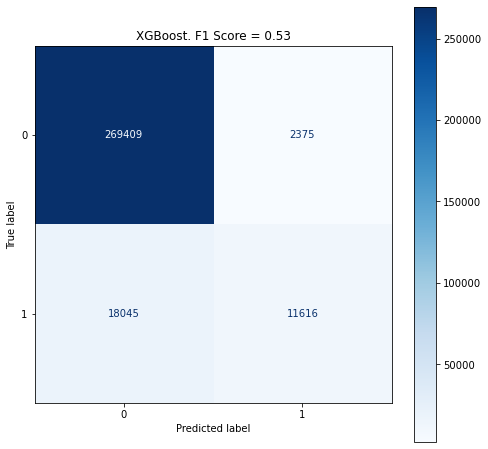

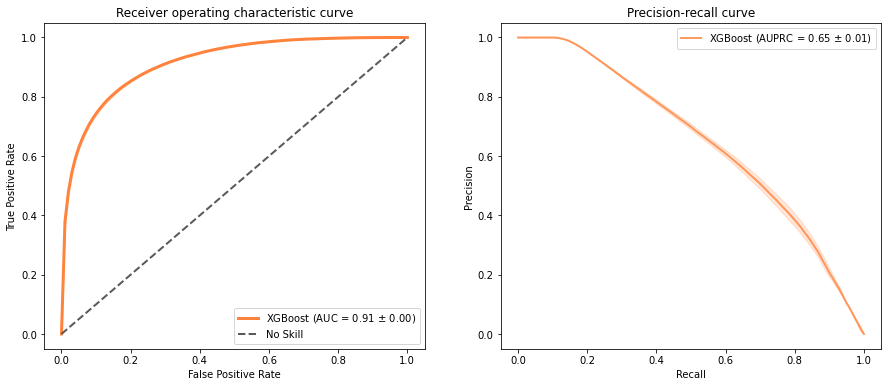

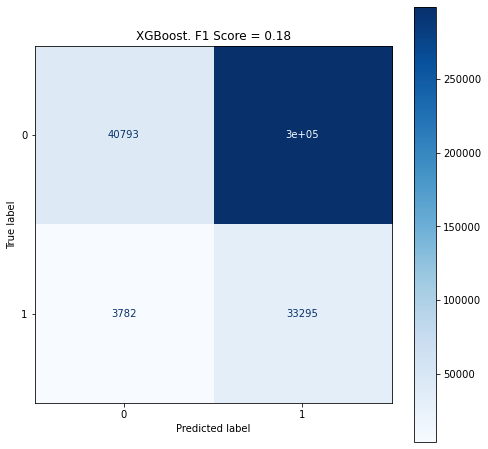

In [7]:
affirm.predict()

0.6356395724307593


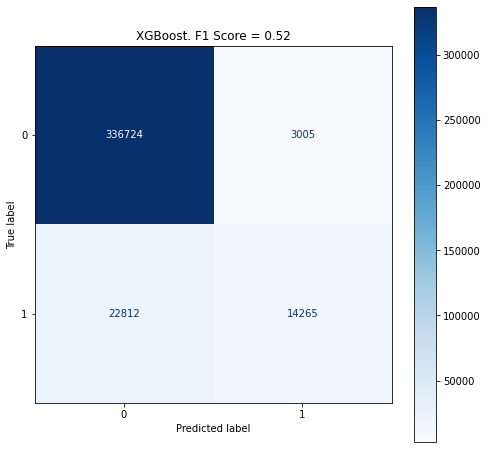

In [9]:
affirm.initial_prediction()

In [10]:
pred_df = affirm.predictions_df

In [13]:
pred_df['False Pos'] = pred_df.where((pred_df['y_test'] == 0) & (pred_df['y_pred'] == 1) & (pred_df['Intervention'] == 1) ).Intervention.replace(np.nan, 0)

In [16]:
def calc_auprc(y_test,y_pred):
    precision,recall,  _ = precision_recall_curve(y_test, y_pred) # calculate recall and precision
    AUPRC = auc(recall, precision) # calculate area under the precision-recall curve
    return AUPRC

pred_df = affirm.predictions_df

calc_auprc(pred_df.y_test, pred_df.Intervention)

pred_df['new_y_test'] = pred_df[['y_test','Intervention']].max(axis = 1).astype(int)
pred_df['false_pos_y_test'] =pred_df[['y_test','False Pos']].max(axis = 1).astype(int)
print(calc_auprc(pred_df.new_y_test, pred_df.y_pred))
print(calc_auprc(pred_df.false_pos_y_test, pred_df.y_pred))
print(calc_auprc(pred_df.y_test, pred_df.y_pred))

0.5980053777724568
0.6441579300505218
0.6356395724307593


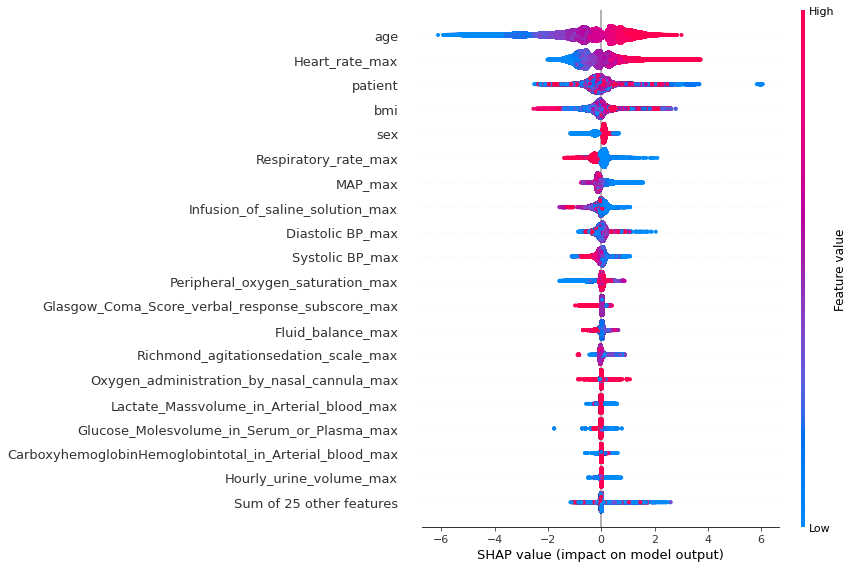

In [17]:
affirm.plot_feature_importances('XGBoost')

In [18]:
affirm.top_features

array(['age', 'Heart_rate_max', 'patient', 'bmi', 'sex',
       'Respiratory_rate_max', 'MAP_max',
       'Infusion_of_saline_solution_max', 'Diastolic BP_max',
       'Systolic BP_max', 'Peripheral_oxygen_saturation_max',
       'Glasgow_Coma_Score_verbal_response_subscore_max',
       'Fluid_balance_max', 'Richmond_agitationsedation_scale_max',
       'Oxygen_administration_by_nasal_cannula_max',
       'Lactate_Massvolume_in_Arterial_blood_max',
       'Glucose_Molesvolume_in_Serum_or_Plasma_max',
       'CarboxyhemoglobinHemoglobintotal_in_Arterial_blood_max',
       'Hourly_urine_volume_max',
       'Glasgow_Coma_Score_eye_opening_subscore_max'], dtype=object)

In [15]:
affirm.predict()

KeyboardInterrupt: 